In [269]:
import matplotlib.pyplot as plt

import importlib
import sys

if '..' not in sys.path:
   sys.path.append('..')

from ehr2vec.binary_tmle import estimators, simulate_data
importlib.reload(estimators)
importlib.reload(simulate_data)

from ehr2vec.binary_tmle.estimators import IPTW_estimator, TMLE_estimator, iterative_TMLE_estimator
from ehr2vec.binary_tmle.simulate_data import (
    compute_ATE_theoretical_from_data, simulate_binary_data, print_basic_stats)

## Simulate binary data and compute theoretical ATE

In [239]:
ALPHA = [0, 0.5, -0.5]
BETA = [-1, 2, 1, -1]

data = simulate_binary_data(10000, alpha=ALPHA, beta=BETA)
ate_th_data = compute_ATE_theoretical_from_data(simulate_binary_data(10000, alpha=ALPHA, beta=BETA), BETA)
# ate_th_model = compute_ATE_theoretical_from_model()
print(f"ATE theoretical from data: {round(ate_th_data, 4)}")
# print(f"from model: {round(ate_th_model, 4)}")

ATE theoretical from data: 0.3493


### Make sure the model is appropriate

In [215]:
print_basic_stats(simulate_binary_data(100, alpha=ALPHA, beta=BETA))

treated patients 52
patients with outcome 51
treated patients with outcome 44
control patients with outcome 7
ORs 6.285714285714286


In [216]:
# check this models too
models = [{'alpha': [0, 0.5, -0.5], 'beta': [-1, 2, 1, -1]},
          {'alpha': [0.2, 1, -1], 'beta': [-1, 2, 1, -1]},
          {'alpha': [0, 0.5, -0.5], 'beta': [1, 5, .1, -2]},
          ]
for model in models:
    data = simulate_binary_data(100, alpha=model['alpha'], beta=model['beta'])
    ate_th_data = compute_ATE_theoretical_from_data(data, model['beta'])
    print(f"ATE theoretical from data: {round(ate_th_data, 4)}")
    print_basic_stats(data)

ATE theoretical from data: 0.3557
treated patients 52
patients with outcome 51
treated patients with outcome 44
control patients with outcome 7
ORs 6.285714285714286
ATE theoretical from data: 0.3557
treated patients 60
patients with outcome 51
treated patients with outcome 48
control patients with outcome 3
ORs 16.0
ATE theoretical from data: 0.3316
treated patients 52
patients with outcome 76
treated patients with outcome 52
control patients with outcome 24
ORs 2.1666666666666665


## IPTW estimator of ATE

In [217]:
data = simulate_binary_data(200, alpha=ALPHA, beta=BETA)
ate_iptw = IPTW_estimator(data)    
print(f"ATE IPTW: {ate_iptw}")
print("Difference between theoretical and IPTW ATE:", round(ate_th_data - ate_iptw, 4))

ATE IPTW: 0.4807683200112904
Difference between theoretical and IPTW ATE: -0.1492


## TMLE estimator of ATE

In [253]:
importlib.reload(estimators)
importlib.reload(simulate_data)

from ehr2vec.binary_tmle.estimators import IPTW_estimator, TMLE_estimator, iterative_TMLE_estimator
from ehr2vec.binary_tmle.simulate_data import (
    compute_ATE_theoretical_from_data, simulate_binary_data, print_basic_stats)
data = simulate_binary_data(1000, alpha=ALPHA, beta=BETA, seed=44)
print('ATE from TMLE', TMLE_estimator(data))
print("Difference between theoretical and TMLE ATE:", round(ate_th_data - TMLE_estimator(data), 4))

ATE from TMLE 0.29384112695541514
Difference between theoretical and TMLE ATE: 0.0473


## Iterative TMLE estimator of ATE

In [262]:
data = simulate_binary_data(1000, alpha=ALPHA, beta=BETA, seed=42)
iter_tmle_ate = iterative_TMLE_estimator(data)
print('ATE from from iter TMLE', iter_tmle_ate)
print("Difference between theoretical and iter TMLE ATE:", round(ate_th_data - iter_tmle_ate, 4))

|||eps -1.734723475976807e-18
ATE from from iter TMLE 0.37617052613561663
Difference between theoretical and iter TMLE ATE: -0.035


## Make sure we have a proper model

In [267]:
# create a curve of a difference to the "true" ATE for IPTW and TMLE vs number of patients]

n_arr = [100, 200, 400, 800, 1600, 3200, 6400, 12800]
# [50, 100, 200, 400, 800, 1600, 3200, 6400, 12800]
tmle_diff = {'model1': [], 'model2': [], 'model3': []}
iptw_diff = {'model1': [], 'model2': [], 'model3': []}
iter_tmle_diff = {'model1': [], 'model2': [], 'model3': []}
models = [{'alpha': [0, 0.5, -0.5], 'beta': [-1, 2, 1, -1]},
          {'alpha': [0.2, 1, -1], 'beta': [-1, 2, 1, -1]},
          {'alpha': [0, 0.5, -0.5], 'beta': [1, 5, .1, -2]},
          ]

for i, model in enumerate(models):
    print(f"Model {i+1}")
    ate_th_data = compute_ATE_theoretical_from_data(simulate_binary_data(10000, **model), model['beta'])
    for n in n_arr:
        data = simulate_binary_data(n, **model)
        ate_iptw = IPTW_estimator(data)
        ate_tmle = TMLE_estimator(data)
        # ate_iter_tmle = iterative_TMLE_estimator(data)
        tmle_diff[f'model{i+1}'].append(ate_th_data - ate_tmle)
        iptw_diff[f'model{i+1}'].append(ate_th_data - ate_iptw)
        # iter_tmle_diff[f'model{i+1}'].append(ate_th_data - ate_iter_tmle)


Model 1
Model 2
Model 3


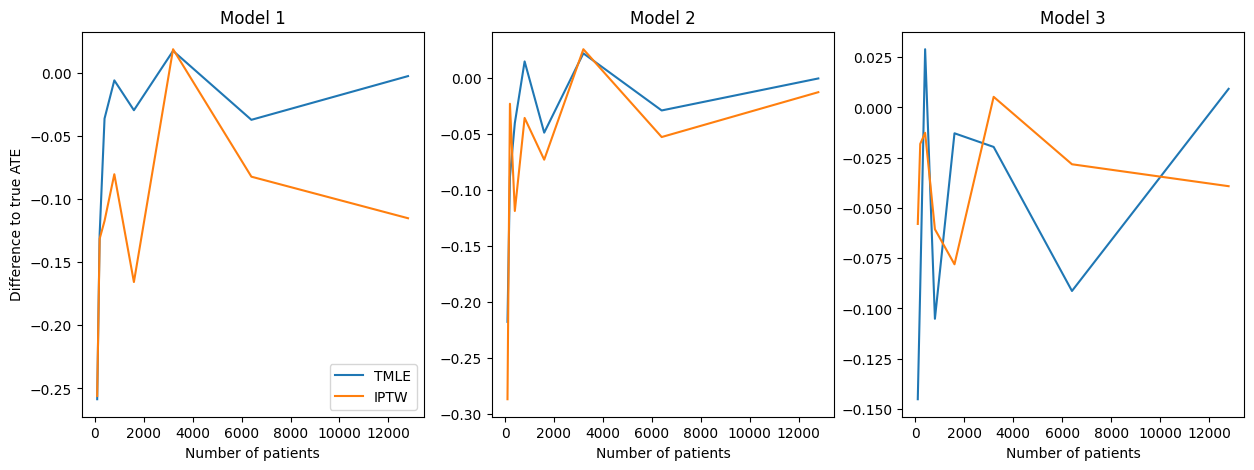

In [268]:
fig, ax = plt.subplots(1,3, figsize=(15, 5))
for i, model in enumerate(models):
    # ax[i].plot(n_arr, iter_tmle_diff[f'model{i+1}'], label='Iterative TMLE')
    ax[i].plot(n_arr, tmle_diff[f'model{i+1}'], label='TMLE')
    ax[i].plot(n_arr, iptw_diff[f'model{i+1}'], label='IPTW')
    ax[i].set_xlabel('Number of patients')
    if i == 0:
        ax[i].set_ylabel('Difference to true ATE')
        ax[i].legend()  

    ax[i].set_title(f'Model {i+1}')